# Tests Statistiques

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import *

data = pd.read_csv("../output/cleaned_data/data_transformed.csv", parse_dates=['date'])
data.head()

,date,airline,dep_time,from,time_taken,stop,arr_time,to,price,class,period
0,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
1,2022-02-11,Air India,soir,Delhi,court,0-stop,soir,Mumbai,25612,business,semaine-1
2,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,soir,Mumbai,42220,business,semaine-1
3,2022-02-11,Air India,soir,Delhi,tres-long,1-stop,nuit,Mumbai,44450,business,semaine-1
4,2022-02-11,Air India,apres-midi,Delhi,long,1-stop,nuit,Mumbai,46690,business,semaine-1


À cette étape de notre analyse, la mission sera de vérifier les hypothèses émises lors de l'analyse descriptive (univariée et bivariée). Que ce soit pour vérifier si la distribution d'une variable suit une loi normale, ou l'existence éffective de relation entre nos variables.

### 1. La distribution des prix de vols, suit-elle une distribution normale ?

Lors de l'analyse univariée, nous avions émis l'hypothèse selon laquelle la distibution des prix des vols éffectués en classe business suivait une loi normale.

![](../output/figures/distribution_des_prix_de_vols.png)

Nous vérifierons cela à travers un test de normalité. Ici notre échantillon étant très grand, nous utiliserons le test d'Anderson-Darling

Pour cela, on commencera par émettre nos hypothèses :
- Hypothèse nulle H0 : Ces données suivent une distribution normale
- Hypothèse alternative H1 : Ces données ne suivent pas une distribution normale

In [31]:
business_prices = data.loc[data['class'] == "business", "price"]
result = anderson(business_prices)

print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 551.4633476008457
significance_level: 15.0 -> critical_values: 0.576
significance_level: 10.0 -> critical_values: 0.656
significance_level: 5.0 -> critical_values: 0.787
significance_level: 2.5 -> critical_values: 0.918
significance_level: 1.0 -> critical_values: 1.092


Interprétation : On constate que la statistique A² est supérieur aux valeurs critiques, quel que soit le seuil.
→ Conclusion : On rejette l'hypothèse nulle et par conséquent, cette distribution ne suit pas une loi normale.

In [32]:
Q1 = np.percentile(business_prices, 0.25); Q3 = np.percentile(business_prices, 0.75)
IQR =  Q3 - Q1
mini = Q1 - 1.5 * IQR; maxi = Q3 + 1.5 * IQR
business_prices = business_prices[(business_prices > mini) & (business_prices < maxi)]

In [33]:
result = anderson(business_prices)

print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 139.7205257289088
significance_level: 15.0 -> critical_values: 0.575
significance_level: 10.0 -> critical_values: 0.655
significance_level: 5.0 -> critical_values: 0.786
significance_level: 2.5 -> critical_values: 0.917
significance_level: 1.0 -> critical_values: 1.091


Même après suppression des Outliers, le résultat est le même. Cette distribution ne suit pas une loi normale.

À présent, on effectue le même processus pour les prix des vols de la classe économique

In [37]:
economic_prices = data.loc[data['class'] == "economy", 'price'].dropna()

result = anderson(economic_prices)
print(f"Statistique A²: {result.statistic}")
for sl, cv in zip(result.significance_level, result.critical_values):
    print(f"significance_level: {sl} -> critical_values: {cv}")

Statistique A²: 7684.822529700468
significance_level: 15.0 -> critical_values: 0.576
significance_level: 10.0 -> critical_values: 0.656
significance_level: 5.0 -> critical_values: 0.787
significance_level: 2.5 -> critical_values: 0.918
significance_level: 1.0 -> critical_values: 1.092


Interprétation : La statistique A² est également supérieur à toutes les valeurs critiques.
→ Conclusion : On rejette l'hypothèse nulle, et par conséquent cette distribution ne suit pas une loi normale.

### 2. Y a-t-il une période où une compagnie aérienne compte plus de vols que d'autres ?

Pour cette question, nous avions retenu que les voyageurs montraient une préférence marquée et
constante pour la compagnie aérienne Vistara, mais que cela était indépendamment de la période. Donc à présent vérifions cette hypothèse.

Nous sommes face à deux variables catégorielles, les deux constituées de 8 groupes. On utilisera donc le test du chi².

On commence par émettre nos hypothèses :
- Hypothèse nulle H0 : La compagnie aérienne choisie pour un vol ne dépend pas de la période.
- Hypothèse alternative H1 : La compagnie aérienne choisie pour un vol dépend de la période.

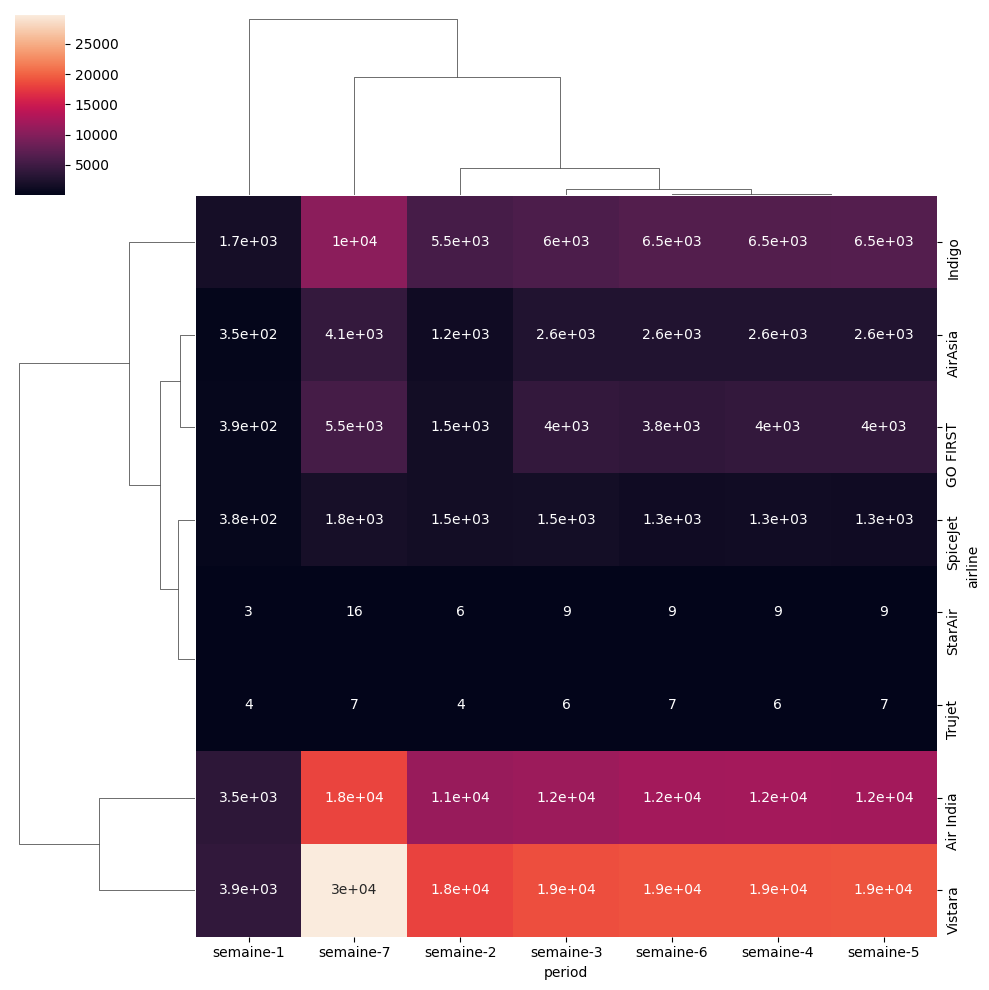

In [45]:
# Visualisation
period = data["period"]
airline = data["airline"]
table_contingency = pd.crosstab(airline, period)

sns.clustermap(table_contingency, annot=True)
plt.show()

In [59]:
def cramers_v(table):
    # Tableau croisé
    chi_2, _, _, _ = chi2_contingency(table)
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi_2 / (n * (min(r, k) - 1)))

print(f"")

chi2_stat, p_value, dof, expected = chi2_contingency(table_contingency)
print(f"chi²: {chi2_stat}\np_value: {p_value}\ndegré de liberté: {dof}\nV de Cramer: {cramers_v(table_contingency)}\nFréquence attendues: {expected}")


chi²: 389.58601059417384
p_value: 3.534266385627485e-64
degré de liberté: 30
V de Cramer: 0.016111068763343613
Fréquence attendues: [[ 1816.25448894  6971.05769167  7934.61388424  8108.10738152
   8101.52352573  8062.02039096 12421.42263693]
 [  363.3529059   1394.60306081  1587.36841649  1622.07686004
   1620.7597191   1612.8568735   2484.98216415]
 [ 4303.72237509 16518.33327781 18801.53663444 19212.6397319
  19197.0388964  19103.43388344 29433.29520091]
 [  875.26363006  3359.3933547   3823.73670307  3907.34423117
   3904.17143266  3885.13464165  5985.95600669]
 [  116.05123225   445.42207061   506.98936978   518.07489456
    517.65421311   515.13012439   793.67809529]
 [ 2732.35536774 10487.1905444  11936.75499197 12197.75690081
  12187.85221299 12128.42408605 18686.66589602]]


La p valeur étant inférieur à 0.05, on rejette l'hypothèse nulle H0. Par conséquent, il existe un lien entre la période et la compagnie aérienne empruntée pour les vols. Cependant, le V de Cramer étant très faible (inférieur à 0.1), ce lien est donc négligeable.
→ L'hypothèse selon laquelle les voyageurs montrent une préférence pour une compagnie aérienne indépendamment de la période est ainsi vérifiée.

### 3. Quel moment de la journéee est priviligié dans une période X donnée pour le départ d'un vol ?

Ici, nous avions retenu que les voyageurs montraient une préférence forte et
constante pour les vols du matin, mais que cela était également indépendamment de la période. Donc à présent vérifions cette hypothèse.

Nous sommes face à deux variables catégorielles, l'une constituée de huit groupes et l'autre de six. On utilisera donc aussi le test du chi².

On commence par émettre nos hypothèses :
- Hypothèse nulle H0 : Le moment de la journée choisie pour le départ d'un vol ne dépend pas de la période.
- Hypothèse alternative H1 : Le moment de la journée choisie pour le départ d'un vol dépend de la période.

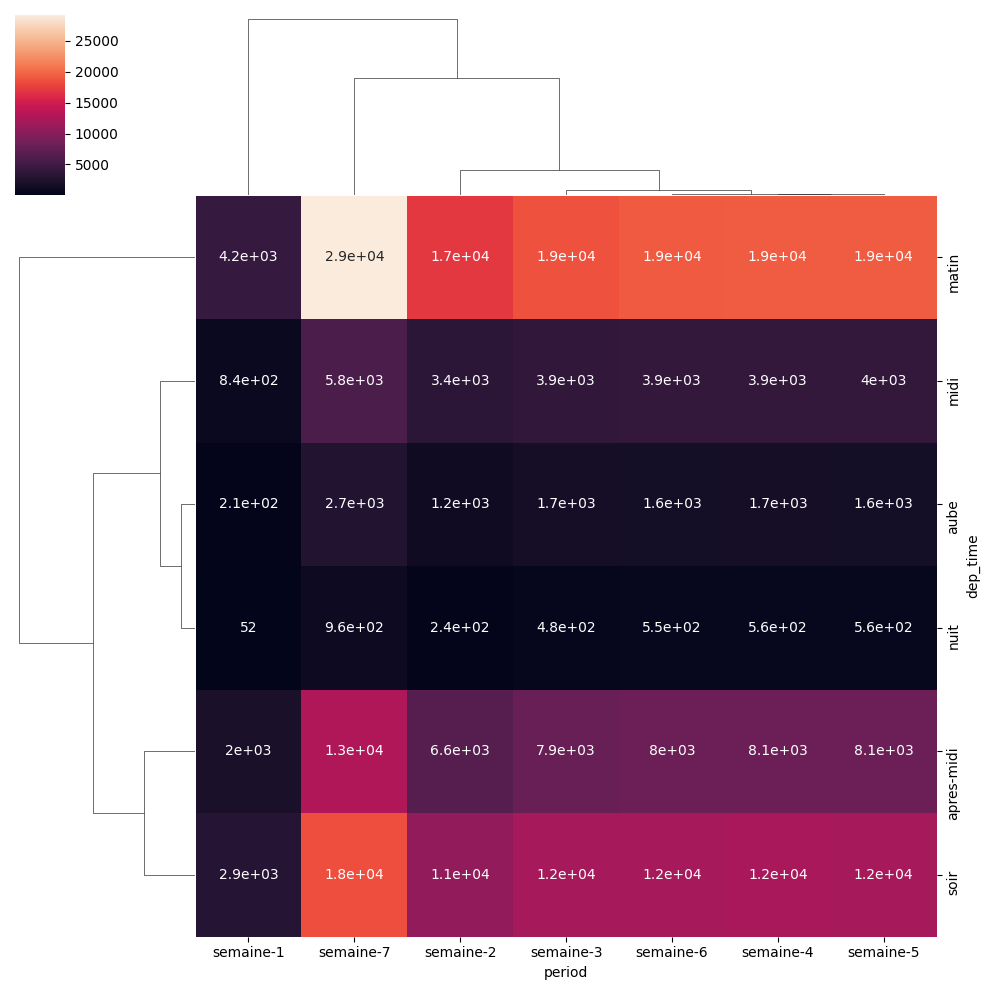

In [62]:
# On construit le tableau de contingence
dep_time = data.dep_time
table_contingency = pd.crosstab(dep_time, period)
# Puis, on visualise nos deux varibles à travers un clustermap
sns.clustermap(table_contingency, annot=True)
plt.show()

In [61]:
# Enfin, on effectue le test du chi²
chi2_stat, p_value, dof, expected = chi2_contingency(table_contingency)
print(f"chi²: {chi2_stat}\np_value: {p_value}\ndegré de liberté: {dof}\nV de Cramer: {cramers_v(table_contingency)}\nFréquences attendues: {expected}")

chi²: 389.58601059417384
p_value: 3.534266385627485e-64
degré de liberté: 30
V de Cramer: 0.016111068763343613
Fréquences attendues: [[ 1816.25448894  6971.05769167  7934.61388424  8108.10738152
   8101.52352573  8062.02039096 12421.42263693]
 [  363.3529059   1394.60306081  1587.36841649  1622.07686004
   1620.7597191   1612.8568735   2484.98216415]
 [ 4303.72237509 16518.33327781 18801.53663444 19212.6397319
  19197.0388964  19103.43388344 29433.29520091]
 [  875.26363006  3359.3933547   3823.73670307  3907.34423117
   3904.17143266  3885.13464165  5985.95600669]
 [  116.05123225   445.42207061   506.98936978   518.07489456
    517.65421311   515.13012439   793.67809529]
 [ 2732.35536774 10487.1905444  11936.75499197 12197.75690081
  12187.85221299 12128.42408605 18686.66589602]]


La p valeur étant aussi inférieur à 0.05, on rejette l'hypothèse nulle H0. Par conséquent, il existe un lien entre la période et le moment de la journée choisie pour les vols. Cependant, le V de Cramer étant très faible (inférieur à 0.1), ce lien est donc négligeable.
→ L'hypothèse selon laquelle les voyageurs montrent une préférence pour les départs de vols en matinée indépendamment de la période est ainsi vérifiée.